# Comparing ADAM to MCMC

## Bayesian Optimization
### Terminology
* Objective function, $f(x)$, the function we want to maximize, we assume $f: \mathcal{X} \to \mathbb{R}$

### Introduction
This notebook aims to illustrate the existing functionality in BoTorch for different methods of handeling the hyperparameter optimization of a gaussian process surrogate model; for bayesian optimization. For brevity discussion of different surrogate models is ommited, but both methods are generally suitable for parametric surrogate models.

In Bayesian Optimization for an arbitrary acquisition function we wish to find the $arg\:max_{x \in \mathbb{X}} \alpha(x \mid \theta)$. We can and often do choose $\theta$ through an optimizer (e.g. ADAM). Alternatively we can consider the distribution of $\theta$ such that we now wish to find.
$$
arg\:max_{x\in\mathcal{X}} \int_\Theta \alpha(x\mid\theta)P(\theta)\,d\theta
\tag{1}
$$
This integral is of course intractable, a very popular way of approximating intractable integrals is monte carlo methods the most commonly used monte carlo methos is Markov Chain Monte Carlo (MCMC). 

The conclusion which we aim to draw in the remainder of the notebook is that the approximation of (1) through MCMC leads to better evaluations of an objective function than choosing $\theta$ to be a single value found through an optimizer. This conclusion is one that is supported in the literature.

### Gaussian Processes (GPs)
**Important Note** It is not neccessary to understand the maths in this section the only important takeaways are, **1.** a GP is defined by a kernel, **2.** a kernel's performace is dependant on hyperparameters $\theta$, **3.** there exists a likelihood equation which defines how well a kernel fits the data, **4.** there is closed form equation for the gradient of this likelihood equation.


A GP is a kernel based modelling method for set of points $X = [\textbf{x}_1, \dots, \textbf{x}_n]$, $\textbf{x}_i \in \mathcal{X},\; \forall i \in \{1,\dots,n\}$ with a corresponding vector $\textbf{y} = [y_1, \dots , y_n],\; y_i = f(\textbf{x}_i),\; \forall i \in \{1,\dots,n\}$. A kernel function $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ defines the believed similarity between two points. Where $K_{XX}$ is a matrix $\mathbb{R}^{n\times n}$, with $[K_{XX}]_{ij} = k(\textbf{x}_i, \textbf{x}_j)$

A simple example of a kernel function is a Radial Basis Function (RBF) with 
$$k(\textbf{x}, \textbf{x}') = \exp\left(-\frac{\lVert \textbf{x}- \textbf{x}' \rVert}{2l^2}\right)
$$
Allow $\theta$ to be a vector of hyperparameters in the case of an RBF kernel $\theta = [l]$ but generally more complex kernel functions will have more than one hyperparameter, all of which need tuning. Using a hat to denote an added diagonal of noise, $\hat{K}_{XX} = K_{XX} + \sigma_n^2\textbf{I}$, we have an additional tunable parameter (now $\theta = [l, \sigma_n]$) we can write the log marginal likelihood equation as
$$
L(\theta \mid X, \textbf{y}) \propto log\lvert \hat{K}_{XX}\rvert - \textbf{y}^T\hat{K}_{XX}^{-1}\textbf{y},
$$
$$
\frac{dL}{d\theta} = \textbf{y}^T\hat{K}_{XX}^{-1}\frac{\hat{K}_{XX}}{d\theta}\hat{K}_{XX}^{-1}\textbf{y} + Tr\left(\hat{K}_{XX}^{-1}\frac{\hat{K}_{XX}}{d\theta}\right),
$$
With $Tr(\cdot)$ as the trace. 



## MCMC
### Explanation
Markov Chain Monte Carlo (MCMC) is a class of algorithms for inferring / exploring a probability distribution. In its simplest implementation we have some target distribution $\pi(x)$ and we can explore this distribution by considering a chain of point vectors starting at $x_0$, we then propose a new point $x^*  \sim q(x^* \mid x_{t})$ where q is the proposal distribution which can be as simple as $\mathcal{N}(0, \textbf{I})$ and then the new point is accepted or rejected in accordance with an acception probability:
$$
\alpha(x_t,\,x^*) = min\left[1,\, \frac{\pi(x^*)q(x_t\mid x^*)}{\pi(x)q(x^*\mid x_t)}\right]
$$
As an algorithm:
$$
\begin{aligned}
&\textbf{Inputs: } x_0,\, q(\cdot),\, n_{iters} \\
&\textbf{for } t = \{0, \dots, n_{iters}-1\}: \\
&\quad x^* \sim q \\
&\quad u \sim \text{Uniform}[0,1) \\
&\quad x_{t+1} =
\begin{cases}
x^*\,, & \text{if } \alpha(x_t, x^*) > u \\
x_t\,, & \text{otherwise}
\end{cases}
\end{aligned}
$$

### Example

All this basically means is given enough iterations, and an appropriate proposal distribution (which can be gradient based) we can infer a target probability distribution just by looking at a histogram of the points visited in the chain, this is showed in the code below:

(a caveat being that if our initial proposal $x_0$ is bad early samples should be thrown out, referred to as burn-in or warm-up steps)

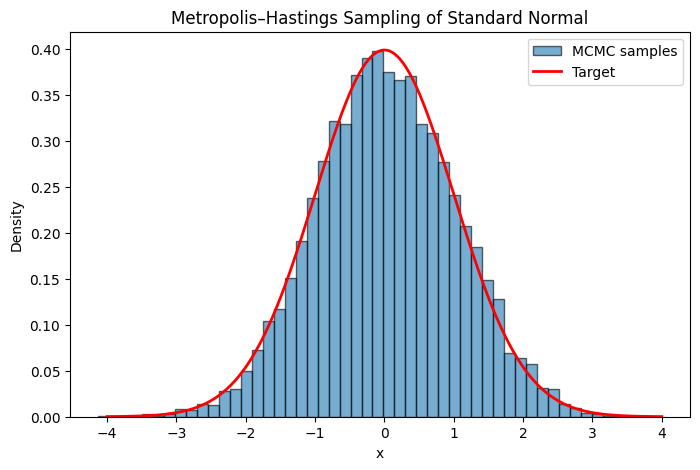

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def target_pdf(x):
    """Standard normal probability density function."""
    return norm.pdf(x, loc=0, scale=1)

def propose(x, proposal_std=1.0):
    """Propose a new point from a Normal(x, proposal_std^2)."""
    return np.random.normal(x, proposal_std)

def acceptance_prob(x, x_prop):
    """Compute Metropolis-Hastings acceptance probability."""
    return min(1, target_pdf(x_prop) / target_pdf(x))

def run_mcmc(n_samples=10000, x0=0.0, proposal_std=1.0):
    samples = np.zeros(n_samples)
    x_current = x0
    for i in range(n_samples):
        x_prop = propose(x_current, proposal_std)
        alpha = acceptance_prob(x_current, x_prop)
        if np.random.rand() < alpha:
            x_current = x_prop  # accept move
        samples[i] = x_current
    return samples

np.random.seed(42)
samples = run_mcmc(n_samples=20000, x0=0.0, proposal_std=1.0)

x_grid = np.linspace(-4, 4, 400)
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, label="MCMC samples", edgecolor='black', linewidth = 1.0)
plt.plot(x_grid, target_pdf(x_grid), 'r-', lw=2, label="Target")
plt.title("Metropolis–Hastings Sampling of Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

## Preamble Code

We begin with defining a dataset class for readability the specifics of the class are not important, it just handels the storing of evaluations of the sythetic objective functions.

In [ ]:
import torch
from tests.target_functions import BaseTarget

class Dataset():
    def __init__(
            self, 
            target: BaseTarget,
        ) -> None:
        self.target = target
        self.X: torch.Tensor | None = None
        self.y: torch.Tensor | None = None
        return

    def random_evals(
            self, 
            seed: int, 
            n_iters: int
        ) -> None:
        assert self.X is None and self.y is None
        random_gen = torch.Generator().manual_seed(seed)
        rand_vals = torch.rand(size = (n_iters, self.target.dim), 
                               generator=random_gen)
        X = self.target.bounds[0] + (self.target.bounds[1]-self.target.bounds[0]) * rand_vals
        y = torch.tensor([self.target.sample(x) for x in X])
        self.X = X
        self.y = y.reshape(-1, 1)

    def eval_x(
            self,
            x_star: torch.Tensor,
    ) -> None:
        y_star = self.target.sample(x_star)
        self.X = torch.cat((self.X, x_star.unsqueeze(0)))
        self.y = torch.cat((self.y, y_star.reshape((-1,1))))
        return

c:\Users\seanp\OneDrive\Desktop\my_repos\bosmc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For the target functions used visit `tests > target_functions` for declarations, or see [botorch docs](https://botorch.readthedocs.io/en/latest/test_functions.html) for information on the target funcitons, the dimensions used for each will be indicated on any plots generated.

## Main Code 

In [2]:
MODEL_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from botorch.models import SingleTaskGP, SaasFullyBayesianSingleTaskGP

from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll, fit_fully_bayesian_model_nuts, ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf

from tqdm import tqdm
import pickle

import os

def ADAM_BO(
        target: BaseTarget,
        seed: int,
        n_random_evals: int,
        n_bo_evals: int,
        disable_prog_bar: bool = True,
        save_results: bool = True
    ) -> dict:
    assert target.num_evals == 0, 'target must not have been evaluated'
    
    dataset = Dataset(target)
    dataset.random_evals(seed, n_random_evals)

    for _ in tqdm(range(n_bo_evals), 
                  disable = disable_prog_bar):
        gp = SingleTaskGP(train_X=dataset.X,
                          train_Y=dataset.y,
                          input_transform=Normalize(d=target.dim),
                          outcome_transform=Standardize(m=1),)
        gp.to(MODEL_DEVICE)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        logEI = LogExpectedImprovement(model=gp, best_f=dataset.y.max())
        x_star, acq_val = optimize_acqf(logEI, bounds=target.bounds, q=1, num_restarts=5, raw_samples=20)
        x_star = x_star[0]
        dataset.eval_x(x_star)

    results = target.get_results()

    if save_results:
        save_name = f'data/notebook_plot_data/{target.target_name}_ADAM.pkl'

        with open(save_name, "wb") as f:
            pickle.dump(results, f)

    return results

def MCMC_BO(
        target: BaseTarget,
        seed: int,
        n_random_evals: int,
        n_bo_evals: int,
        warm_up_steps: int,
        num_samples: int,
        thinning: int,
        disable_prog_bar: bool = True,
        save_results: bool = True,
    ) -> dict:
    assert target.num_evals == 0, 'target must not have been evaluated'
    
    dataset = Dataset(target)
    dataset.random_evals(seed, n_random_evals)

    for _ in tqdm(range(n_bo_evals), 
                  disable = disable_prog_bar):
        model = SaasFullyBayesianSingleTaskGP(
            train_X=dataset.X,
            train_Y=dataset.y,
            input_transform=Normalize(d=target.dim),
            outcome_transform=Standardize(m=1),)
        model.to(MODEL_DEVICE)
        fit_fully_bayesian_model_nuts(
            model = model,
            warmup_steps=warm_up_steps,
            num_samples=num_samples,
            thinning=thinning,
            disable_progbar=True,
        )
        logEI = LogExpectedImprovement(model=model, best_f=dataset.y.max())
        
        x_star, acq_val = optimize_acqf(logEI, bounds=target.bounds, q=1, num_restarts=5, raw_samples=20)
        x_star = x_star[0]
        dataset.eval_x(x_star)

    results = target.get_results()

    if save_results:
        save_name = f'data/notebook_plot_data/{target.target_name}_MCMC.pkl'

        with open(save_name, "wb") as f:
            pickle.dump(results, f)

    return results

## Test Running

In [4]:
import time
from tests.target_functions import Ackley, Branin, Hartmann, Rosenbrock

N_RANDOM_EVALS = 5
N_BO_EVALS = 1
SEED = 1

target_classes: list[BaseTarget] = [Ackley, Branin, Hartmann, Rosenbrock]
test_fns: list[callable] = [ADAM_BO, MCMC_BO]
# arguments common accross both test functions
common_args: dict = {'n_random_evals': N_RANDOM_EVALS, 'n_bo_evals': N_BO_EVALS, 'seed': SEED}

# MCMC takes extra args the number of MCMC iterations is warm_up_steps + num_samples
# a thinning of 1 means all of num_samples are used to infer P(\theta)
test_args: list[dict] = [{}, {'warm_up_steps': 256, 'num_samples': 128, 'thinning': 1,}]

results_text = []
for target_class in target_classes:
    for i, test_fn in enumerate(test_fns):
        target: BaseTarget = target_class()
        start_time = time.time()
        test_fn(target = target, **common_args, **(test_args[i]))
        end_time = time.time()
        
        text_line = (f'{test_fn.__name__} took {end_time-start_time} seconds to run on the {target.dim}',
                    f' dimensional {target.target_name} synthetic test function')
        results_text.append(text_line)
        print(text_line)

tensor([[-32.7680, -32.7680, -32.7680, -32.7680, -32.7680, -32.7680, -32.7680,
         -32.7680, -32.7680, -32.7680],
        [ 32.7680,  32.7680,  32.7680,  32.7680,  32.7680,  32.7680,  32.7680,
          32.7680,  32.7680,  32.7680]], dtype=torch.float64)


ValueError: Expected `X` to be within the bounds of the test problem.

## Plotting